In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

In [2]:
# Earth parameters
rho       = 1.225                # kg/m^3
G         = 6.67430e-11          # m^3 kg^-1 s^-2
M_earth   = 5.972e24             # kg
R_earth   = 6_371_000            # m
H_scale   = 8_400                # m   – 1‑e scale height for a crude ρ(h) model
mu        = G * M_earth

# Object parameters
C = 0.5                      # drag coefficient
x_area = 0.1                    # m^2
mass = 100                      # kg
h0   = 30_000               # m   – launch altitude
r0   = R_earth + h0         # m   – launch radius

# Set simulation parameters
sim_time = 1000 # duration
n_steps = 10000 # number of calculations
dt = sim_time/n_steps

In [3]:
def curvature_radius(v_vec, a_vec):
    """
    Calculates radius of curvature in 2D using
    velocity and acceleration vectors
    R = |v|^3 / |v x a|
    """
    # Pull components from vectors
    vx, vy = v_vec
    ax, ay = a_vec

    # Calculate instantaneous speed
    speed = np.linalg.norm(v_vec)

    # 2D magnitude of v x a = (vx*ay - vy*ax)
    cross = abs(vx*ay - vy*ax)

    # Return curvature unless cross product = 0 
    return speed**3 / cross if cross !=0 else np.inf

In [4]:
def acceleration(state):
    """
    Takes in the position and velocity
    and computes acceleration components
    that include gravity and drag
    """

    x,y,vx,vy = state
    r_vec = np.array([x,y])
    v_vec = np.array([vx,vy])

    r = np.linalg.norm(r_vec)
    speed = np.linalg.norm(v_vec)

    # gravity
    g_vec = (-mu/r**3)*r_vec

    # atmosphere
    h = r - R_earth
    rho_local = rho*np.exp(-h / H_scale) if h>= 0 else rho 

    drag_vec = ( 
        -0.5*rho_local*C*x_area/mass * speed*v_vec 
        if speed>0 else np.zeros(2)
    )

    return g_vec + drag_vec

In [5]:
def derivatives(state):
    """
    Returns d(state)/dt
    """

    ax, ay = acceleration(state)
    vx, vy = state[2], state[3]

    return np.array([vx,vy,ax,ay])

def rk4_step(state, dt):

    k1 = derivatives(state)
    k2 = derivatives(state + 0.5*dt*k1)
    k3 = derivatives(state + 0.5*dt*k2)
    k4 = derivatives(state + dt*k3)

    return state+dt/6 * (k1 + 2*k2 + 2*k3 + k4)

In [11]:
def run_trajectory(vx0, dt=0.02, t_max=10000):
    """
    Function to run the actual trajectory and
    determine curvature at launch and impact time
    """

    # Initial state with given horizontal velocity and altitude
    state= np.array([r0, 0.0, 0, vx0])
    t = 0.0

    # Curvature at launch
    a0 = acceleration(state)
    R_launch=curvature_radius(state[2:4], a0)

    # Progress forward until crossing surface or reaching time
    while t< t_max and np.linalg.norm(state[:2]) > R_earth:

        state = rk4_step(state, dt)
        t += dt

    return t if t< t_max else np.nan, R_launch


In [13]:
# Sweep across initial velocity values to find sweet spot for hitting orbit
vxs = np.linspace(4000,10000, 100) # From 4000-9000 in 60m/s increments

# initiate list for storing radii
Rvals=[]

for v in vxs: 
    _, R0 = run_trajectory(v, dt)
    Rvals.append(R0)

# Locate velocity where R0=r0
idx = np.argmin(abs(np.array(Rvals) - r0))
v_crit = vxs[idx]

# Print out critical velocity
print(f"Critical velocity (numerical sol.)at {(r0-R_earth)/1000:.2f}km altitude = {v_crit:0.1f} m/s")

# Compare to analytical solution for orbital velocity of a perfectly circular orbit
v_check = np.sqrt(mu/(r0))
print(f"Critical velocity (analytical sol., no drag) at {(r0-R_earth)/1000:.2f}km altitude = {v_check :.2f} m/s")

Critical velocity (numerical sol.)at 30.00km altitude = 7878.8 m/s
Critical velocity (analytical sol., no drag) at 30.00km altitude = 7891.12 m/s


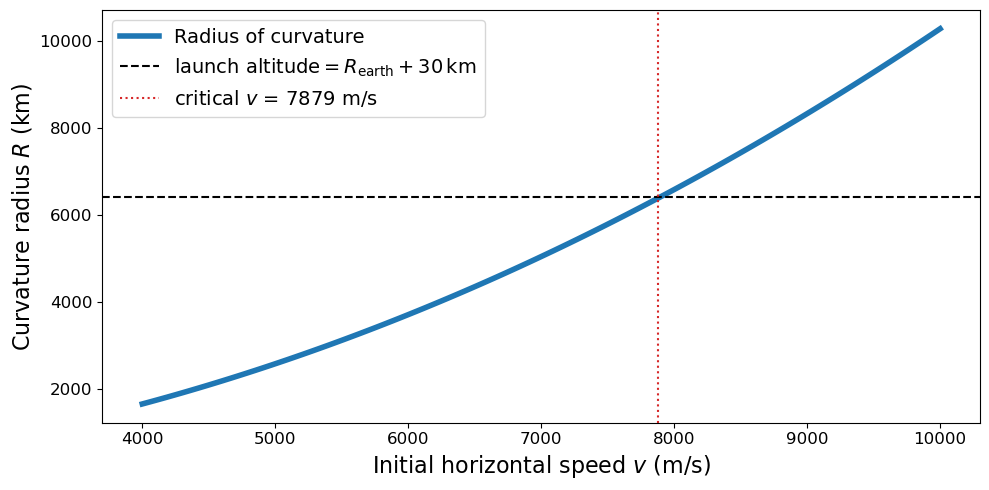

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(vxs, [R/1000 for R in Rvals], label='Radius of curvature', linewidth=4)
plt.axhline(r0/1000, color='k', linestyle='--',
            label=rf'$\mathrm{{launch \ altitude}} = R_\mathrm{{earth}}+{h0/1000:.0f}\,\mathrm{{km}}$')
plt.axvline(v_crit, color='C3', linestyle=':',
            label=rf'critical $v$ = {v_crit:.0f} m/s')

plt.xlabel('Initial horizontal speed $v$ (m/s)', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Curvature radius $R$ (km)', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()